<a href="https://colab.research.google.com/github/Chihiro-n/stockmodel/blob/master/LSTM_Stock_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NNで株価を予測モデルを作成する
rev2:入力データを一次元に限定

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# LSTMモデルを組む

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%pwd

'/content'

In [5]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [6]:
%ls

'Colaboratory へようこそ のコピー'
 data/
 data_dir/
 DogCat.ipynb
 kaggleデータinputの方法DogCat.ipynb
 keras_ssd_hands-on/
 LSTM_changed_dataset.ipynb
'LSTM_Stock_Classify (1).ipynb'
 LSTM_Stock_Classify.ipynb
 net.ckpt
 prophet/
'PyTorch実践入門ハンズオンセミナー配布用 のコピー'
 RNN_shapeCheak.ipynb
 RNN_sin_pred.ipynb
 sampleSubmission.csv
 torch_tuto_CFIA10.ipynb
 Youtube_Analysis_1.ipynb


# GPUセットのためのおまじない

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データセットを作る
### PytorchのLSTMに学習させるためのデータは次元の工夫が必要であり、二重リストにしないとエラーになる
### 訓練用とテスト用にデータを分ける。まず二重リストであるtmpを作ってからそれを分割した

In [8]:
window = 50   # データは日足

#csvfile = open('/content/drive/My Drive/data-text.csv', 'r', encoding='utf-8')
#df_train_law = pd.read_csv('./data/stock/label_difflog_2005-2018.csv' ,index_col=0)
df_train_law = pd.read_csv('./data/stock/class_label_difflog_2005-2018.csv' ,index_col=0)

df_train_law.head()

inp_dim = len(df_train_law)

train_endindex = int(inp_dim*0.9)



In [9]:
print(df_train_law.head())

              始値    高値    安値    終値  ...  label_m0  label_p0  label_p1  label_class
日付                                  ...                                           
2005-01-05  4210  4220  4140  4150  ...       0.0       0.0       0.0          0.0
2005-01-06  4150  4210  4150  4190  ...       1.0       0.0       0.0          2.0
2005-01-07  4210  4210  4140  4150  ...       0.0       1.0       0.0          3.0
2005-01-11  4180  4210  4170  4200  ...       1.0       0.0       0.0          2.0
2005-01-12  4180  4190  4140  4150  ...       0.0       1.0       0.0          3.0

[5 rows x 17 columns]


### inputデータとして、株価をlogに加工した値のみを取り出す。
最初の行だけは削除しておく。階差をlabelとしているため

In [10]:
#df_input = df_train_law.iloc[:, 4:8 ]
df_input = df_train_law.iloc[:, 4 ]

#nd_cast = open.astype(np.float32)

In [11]:
df_input = df_input.drop('2005-01-05', axis=0)

In [12]:
df_input

日付
2005-01-06    8.330864
2005-01-07    8.345218
2005-01-11    8.338067
2005-01-12    8.338067
2005-01-13    8.321178
                ...   
2018-12-21    8.777864
2018-12-25    8.728264
2018-12-26    8.720787
2018-12-27    8.763115
2018-12-28    8.758570
Name: log始値, Length: 3416, dtype: float64

## 念の為、inputdataを確認しておく

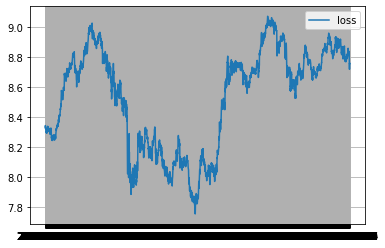

In [13]:
plt.figure()
plt.plot(df_input,label="loss")
plt.legend()
plt.grid()

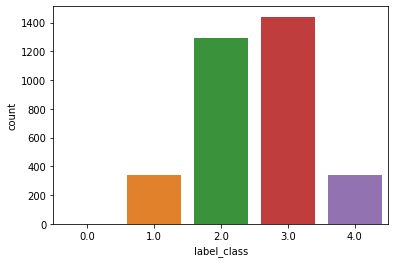

In [44]:
sns.countplot(x="label_class", data=df_train_law)
plt.show()

### inputデータを作成する。
説明変数4つ　が 50日分.  
ループは50を引いておく  
numpyに変更しておく

In [14]:
#train_input = np.array([])
train_input = []

for i in range(len(df_input)-window):
  #train_input = np.append( train_input, df_input.iloc[i: i+window] )
  train_input.append( df_input.iloc[i: i+window].values )

### 中身チェック

In [15]:
print(len(train_input))
print(type(train_input))
#train_input[0]
#print(train_input.shape)


3366
<class 'list'>


### numpyに変更し、サイズもチェック

In [16]:
np_train_input = np.array(train_input)
np_train_input = np_train_input.astype(np.float32)  ### float型に変更しておかないと、modelに入力する際にerrorが出る　※doubleはNG

print(np_train_input.shape)

np_train_input


(3366, 50)


array([[8.330864 , 8.345218 , 8.338066 , ..., 8.308938 , 8.301521 ,
        8.296547 ],
       [8.345218 , 8.338066 , 8.338066 , ..., 8.301521 , 8.296547 ,
        8.296547 ],
       [8.338066 , 8.338066 , 8.321178 , ..., 8.296547 , 8.296547 ,
        8.296547 ],
       ...,
       [8.7904215, 8.773385 , 8.79936  , ..., 8.818778 , 8.7778635,
        8.728264 ],
       [8.773385 , 8.79936  , 8.80162  , ..., 8.7778635, 8.728264 ,
        8.720787 ],
       [8.79936  , 8.80162  , 8.791942 , ..., 8.728264 , 8.720787 ,
        8.763115 ]], dtype=float32)

## input次元が1のときだけ必要になる。shapeを( len , timestep , 1 )にするため。
※reshapeをしない場合は(len , timestep)だけとなってエラーになる

In [17]:
np_train_input = np_train_input.reshape(-1,50,1)
print(np_train_input.shape)

(3366, 50, 1)


# labelデータも numpyに変更しておく
labalはonehot vectorなので、(3366,1,4)になるはず -> X ※pytorchのクロスエントロピーロスはエントロピーロスはonehotvectorに対応しておらずクラスラベルにする

In [18]:
df_label = df_train_law.iloc[:, 16 ]
df_label
#nd_cast = open.astype(np.float32)

日付
2005-01-05    0.0
2005-01-06    2.0
2005-01-07    3.0
2005-01-11    2.0
2005-01-12    3.0
             ... 
2018-12-21    1.0
2018-12-25    1.0
2018-12-26    2.0
2018-12-27    4.0
2018-12-28    2.0
Name: label_class, Length: 3417, dtype: float64

In [19]:
df_label = df_label.drop('2005-01-05', axis=0)

In [20]:
type(df_label)

pandas.core.series.Series

In [21]:
train_label = []

for i in range(len(df_label)-window):
  #train_label.append( df_label.iloc[window + i].values )
  train_label.append( df_label.iloc[window + i] )

In [22]:
np_train_label = np.array(train_label)
np_train_label = np_train_label.astype(np.float32)
np_train_label.shape

(3366,)

## Shapeを変更する、 二重リストの型へ


In [23]:
#np_train_label = np_train_label.reshape(-1,1)

In [24]:
print(np_train_label.shape)
print(np_train_label)


(3366,)
[3. 3. 2. ... 2. 4. 2.]


## TrainとTestで分割する

In [25]:
X_train, y_train, X_test, y_test= [], [], [], []


all_length = len(np_train_label)
train_length = int(all_length*0.9)

### 訓練用データセットを作成するループ
X_train = np_train_input[:train_length]
y_train = np_train_label[:train_length]

### テスト用データセットを作成するループ
X_test = np_train_input[train_length:]
y_test = np_train_label[train_length:]


In [26]:

print(inp_dim)
print( len(X_train[0]) )
print( len(X_train) )

print(X_train[0])
print(X_train[1])
print(X_train[2])

print("=================")
print(y_train[0])
print(y_train[1])

print("=================")
print( len(X_test[0]) )
print( len(X_test) )

print(X_test[0])
print(X_test[1])
print(X_test[2])
print("=================")
print(y_test[0])
print(y_test[1])

3417
50
3029
[[8.330864 ]
 [8.345218 ]
 [8.338066 ]
 [8.338066 ]
 [8.321178 ]
 [8.318742 ]
 [8.323608 ]
 [8.328451 ]
 [8.323608 ]
 [8.3113985]
 [8.304    ]
 [8.306472 ]
 [8.296547 ]
 [8.306472 ]
 [8.308938 ]
 [8.299037 ]
 [8.294049 ]
 [8.306472 ]
 [8.308938 ]
 [8.313852 ]
 [8.299037 ]
 [8.304    ]
 [8.313852 ]
 [8.318742 ]
 [8.321178 ]
 [8.340456 ]
 [8.340456 ]
 [8.33327  ]
 [8.326033 ]
 [8.326033 ]
 [8.335671 ]
 [8.323608 ]
 [8.306472 ]
 [8.306472 ]
 [8.306472 ]
 [8.3163   ]
 [8.308938 ]
 [8.313852 ]
 [8.313852 ]
 [8.313852 ]
 [8.323608 ]
 [8.323608 ]
 [8.318742 ]
 [8.3163   ]
 [8.326033 ]
 [8.326033 ]
 [8.318742 ]
 [8.308938 ]
 [8.301521 ]
 [8.296547 ]]
[[8.345218 ]
 [8.338066 ]
 [8.338066 ]
 [8.321178 ]
 [8.318742 ]
 [8.323608 ]
 [8.328451 ]
 [8.323608 ]
 [8.3113985]
 [8.304    ]
 [8.306472 ]
 [8.296547 ]
 [8.306472 ]
 [8.308938 ]
 [8.299037 ]
 [8.294049 ]
 [8.306472 ]
 [8.308938 ]
 [8.313852 ]
 [8.299037 ]
 [8.304    ]
 [8.313852 ]
 [8.318742 ]
 [8.321178 ]
 [8.340456 ]
 [8.340456 

In [27]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(3029, 50, 1)
(3029,)
(337, 50, 1)
(337,)


### dataloader メソッドで、tensorに変更してくれるから必要なし

In [28]:
"""
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)
"""

'\nX_train = torch.tensor(X_train)\ny_train = torch.tensor(y_train)\n\nX_test = torch.tensor(X_test)\ny_test = torch.tensor(y_test)\n'

## Dataを組むまでの流れ
1. Datasetクラスを作成する 
    1. 入力データと正解データにわける tensorにすること pd->np->tensorに変換する必要がある
    1. \__len__と\__getitem__を用意すること
1. Dataloaderを準備  
Datasetクラスで作ったやつをinputするだけなので難易度は低い
    

 ### datasetクラスを作成する

In [29]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,  X , y , mode='train' ,transform = None):
        self.data = X
        self.label = y
        self.num = len(X)
        self.mode= mode
        self.transform = transform
       
    
    def __len__(self):                         ###データの大きさをreturn するlenメソッドを必ず作成する必要がある
        return self.num
    
    def __getitem__(self, idx):           ###正解データと入力データが対となるようなgetitemメソッドを必ず作成する必要がある
        
        out_data = self.data[idx]
        out_label =  self.label[idx]
        
        return out_data, out_label
        

### XとyをDatasetクラスを継承させて作った自作クラスにinput

In [30]:
trainset = Dataset( X_train , y_train )

In [31]:
#trainset.shape
X_train.shape

(3029, 50, 1)

In [32]:
dataloader = torch.utils.data.DataLoader(dataset=trainset, batch_size = 32 , shuffle=True)

### 中身の確認
### dataloaderを使用したとしてもshapeは、(バッチ、timestep、説明変数次元)の順になる
dataloaderを使用すると、勝手にnumpy型からtorch型に変更されている。

In [33]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

In [34]:
print(X.shape)
print(len(X_train))
print(len(y_train))

torch.Size([32, 50, 1])
3029
3029


# モデルの構築
* input 層
* middle 層
* output 層

In [35]:
import torch
import torch.nn as nn


class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()
        
        self.lstm = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
                           
        self.lstm_output_layer = nn.Linear(hiddenDim, outputDim)
        #self.sigmoid_out = nn.Linear(outputDim, 4)    # labelは one hotベクトルなので outputを4クラスに分けられるようにする
        #self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, inputs, hidden0=None):
        #print(inputs) 　　　　# このinputsには1batchが入る。サイズが4なら 4 ,50, 1 
        output, (hidden, cell) = self.lstm(inputs, hidden0) #LSTM層
        output = self.lstm_output_layer(output[:, -1, :]) #全結合層
        #output = self.sigmoid_out(output)
        return output


In [36]:
#model = Predictor(4,64,4)    # inputの次元は? 株価onlyだから1次元となるのか、それとも時間を5個分とってくるから 5次元？？
model = Predictor(1,64,4).to(device)     ### 隠れ層は50で行う必要がある
model

Predictor(
  (lstm): LSTM(1, 64, batch_first=True)
  (lstm_output_layer): Linear(in_features=64, out_features=4, bias=True)
)

In [37]:
# 損失関数
#criterion = nn.MSELoss()      ### 損失化関数は二乗誤差を設定。　回帰モデルなのでOK
#criterion = nn.CrossEntropyLoss() #ソフトマックス交差エントロピー

criterion = nn.CrossEntropyLoss()



# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)     ### lrは学習率

In [38]:
loss_ = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input)
print(input.shape)
print(target)
print(target.shape)
#output_ = loss_(input, target)
#output_.backward()


tensor([[-0.4198, -0.3068, -0.3447,  0.9974, -1.2025],
        [-0.5369,  0.2672, -0.2689, -0.3466,  0.6472],
        [ 0.4403,  0.5142, -0.1205, -0.1879,  0.7767]], requires_grad=True)
torch.Size([3, 5])
tensor([4, 2, 3])
torch.Size([3])


# dataloaderを使った学習

In [39]:
ls_loss = []
model.train()


for epoch in range(30):
    
    model.train()
    for i, (X, label) in enumerate(dataloader):

        label = label.long()

        X_torch = X.to(device)
        label_torch = label.to(device)



        #print("X shape ",X_torch.shape)
        #print("label shape",label_torch.shape)
        #print("label",label_torch)
        

        label_torch = label_torch -1  ## なんの意味があるがよくわかっていないが、損失関数を計算するときにこれを入れないとエラーになる
                                      ## criterion()にて、 index error Target 4 is out of bounds


        # 勾配の初期化
        optimizer.zero_grad()     
        
        y_pred = model( X_torch )          ### ニューラルネットで計算したoutputを保存
        
        #print("y_pred : ",y_pred)
        #print("y_pred shape: ",y_pred.shape)

        loss = criterion(y_pred, label_torch) ###教師データとoutputから損失関数を計算
        

        # バッチごとのロスを記録する
        ls_loss.append(loss)
        
        # 勾配の計算
        loss.backward()           ### 損失関数を微分 = 勾配の計算
        
        # パラメータの更新
        optimizer.step()           
        
        #print('*** by optimizer.step()')
    

### ロスの確認 dataloader

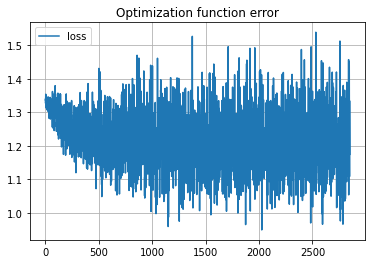

In [40]:
plt.figure()
plt.plot(ls_loss,label="loss")
plt.title('Optimization function error') # 最適化関数の誤差
plt.legend()
plt.grid()

## できあがったmodelでテストを行ってみる

In [41]:
testset = Dataset( X_test , y_test )
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size = 1, shuffle=True)

In [42]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

In [43]:

y_testresult = []
model.eval()
#t = np.arange(50, 58)



for i, (X, label) in enumerate(dataloader):

    print("@@@@@@@@@@@@", i)
    
    print(X)
    optimizer.zero_grad()
    
    y = model(X)
    l = label
    
    print("label",label)
    print(y)
    
    y = y.to('cpu').detach().numpy().copy()
    l = l.to('cpu').detach().numpy().copy()
    
    y_flat = y.flatten()
    l_flat = l.flatten()
    
"""    
    plt.plot(t,y_flat, marker = 'o')
    plt.plot(t,l_flat, marker = 'x')
    plt.show()
"""    

ストリーミング出力は最後の 5000 行に切り捨てられました。
         [8.8192],
         [8.8070],
         [8.7963],
         [8.7895],
         [8.7966],
         [8.8072],
         [8.8106],
         [8.8313],
         [8.8301],
         [8.8561],
         [8.8629],
         [8.8609],
         [8.8542],
         [8.8615],
         [8.8693]]])
label tensor([2.])
tensor([[-0.7618,  0.5157,  0.6357, -0.7503]], grad_fn=<AddmmBackward>)
@@@@@@@@@@@@ 243
tensor([[[8.8676],
         [8.8721],
         [8.8749],
         [8.8683],
         [8.8621],
         [8.8711],
         [8.8742],
         [8.8813],
         [8.8847],
         [8.8697],
         [8.8758],
         [8.8921],
         [8.8919],
         [8.9195],
         [8.9165],
         [8.9160],
         [8.9000],
         [8.9057],
         [8.9044],
         [8.9160],
         [8.9092],
         [8.9137],
         [8.9220],
         [8.9122],
         [8.9064],
         [8.8970],
         [8.8899],
         [8.8774],
         [8.8742],
         [8.8609],
   

"    \n    plt.plot(t,y_flat, marker = 'o')\n    plt.plot(t,l_flat, marker = 'x')\n    plt.show()\n"